<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/gpt_parallelized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Mar 14 16:22:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    55W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Hyperparameters

In [2]:
# hyperparameters
batch_size = 64 # num independent sequences processed in parallel 
block_size = 256 # maximum context length

max_iterations = 5001 # training iterations
eval_interval = 500 # after how many iterations to print out loss & accuracy
eval_iterations = 50 # batches to average over during evaluation

train_split = 0.9

dropout = 0.2
learning_rate = 1e-3 #3e-4

# model architecture
n_heads = 6
n_embedding = 384 # each head has dim 64 (=384/6)
n_layer = 6

## Imports 

In [3]:
try:
    import einops
except:
    print(f"einops not installed as required, installing...")
    !pip3 install einops
    import einops

from einops import rearrange, reduce, repeat

import torch
import torch.nn as nn
import time

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"on device: {device}")

on device: cuda


## Download and pre-process data

In [5]:
# Importing data
data_file_path = 'https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/foundation.txt'
import requests
r = requests.get(data_file_path)
text = r.text

print(f"Length of foundation.txt: {len(text)} characters")
print(text[:250])
print()

chars = sorted(list(set(text)))
n_chars = len(chars)
print(f"There are {n_chars} unique characters, namely: {''.join(chars)}")

ctoi = {ch:i for i, ch in enumerate(chars)} # characters to integers
itoc = {i:ch for i, ch in enumerate(chars)} # integers to character
encode = lambda s: [ctoi[ch] for ch in s]
decode = lambda l: ''.join([itoc[i] for i in l])
print(encode("Hello world!"))
print(decode(encode("Foo Bar!")))

data = torch.tensor(encode(text), dtype=torch.long)
n = int(len(data) * 0.9)
train_data = data[:n]
test_data = data[n:]
print(f"train data length: {len(train_data)} | test data length: {len(test_data)}")

Length of foundation.txt: 1240544 characters
FOUNDATION 
ISAAC ASIMOV 

PART I 

THE PSYCHOHISTORIANS 

i. 

HARI SELDON-... bom In the 1 1,988th year of the Galactic Era; died 12,069. The dates are 
more commonly given In terms of the current Foundational Era as - 79 to the year 1 F.E. Born 
t

There are 84 unique characters, namely: 
 !"#%'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ\abcdefghijklmnopqrstuvwxyz—‘’”
[34, 58, 65, 65, 68, 1, 76, 68, 71, 65, 57, 2]
Foo Bar!
train data length: 1116489 | test data length: 124055


In [6]:
def get_batches(split='train') -> tuple:
  data = train_data if split == 'train' else test_data
  idxs = torch.randint(len(data)-block_size, (batch_size, ))
  xb = torch.stack([data[i:i+block_size] for i in idxs])
  yb = torch.stack([data[i+1:i+block_size+1] for i in idxs])
  xb, yb = xb.to(device), yb.to(device)
  return xb, yb

xb, yb = get_batches()
print(xb.shape, yb.shape)

torch.Size([64, 256]) torch.Size([64, 256])


In [7]:
def evaluate_model(model: nn.Module, eval_iterations = eval_iterations) -> dict:
  t_eval = time.time()
  model.eval()
  with torch.inference_mode():
    splits = ['train', 'test']
    categories = ['loss', 'top1', 'top5']
    all = {s:{c: torch.zeros(eval_iterations) for c in categories} for s in splits}
    for split in splits:
      for i in range(eval_iterations):
        xb, yb = get_batches(split = split)
        logits, loss = model(xb, yb)
        all[split]['loss'][i] = loss.item()

        # top@1 accuracy
        top1_preds = torch.topk(logits, 1, dim = -1).indices.squeeze(dim=-1)
        all[split]['top1'][i] = 100*(torch.sum(top1_preds == yb) / torch.numel(yb)).item()
        # top@5 accuracy
        top5_preds = torch.topk(logits, 5, dim = -1).indices
        y_stretched = repeat(yb, 'B T -> B T K', K = 5)
        all[split]['top5'][i] = 100*(torch.sum(top5_preds == y_stretched) / torch.numel(yb)).item()
  model.train()

  output_dict = {split:list(map(lambda a: round(a.mean().item(), 4), all[split].values())) for split in splits}
  output_dict['eval_time'] = round(time.time()-t_eval, 2)
  return output_dict

def format_output(output_dict, iter, train_time, loss):
  array = [iter,"|"]+output_dict['train']+['|']+output_dict['test']+['|']+[round(train_time,2),output_dict['eval_time'],'|',round(loss.item(),4)]
  title = 'iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)'
  if iter == 0:
    print("----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------")
    print(title)
  idxs = [0]
  for j in range(len(title)-1): 
    if title[j] == " " and title[j+1] != " ": idxs.append(j+1)
  output_str = ""
  for i in range(len(idxs)): output_str+=" "*(idxs[i]-len(output_str)) + f"{array[i]}"
  return output_str

## GPT model

In [8]:
class MultiHeadAttention(nn.Module):
  # parallelized attention heads
  
  def __init__(self):
    super().__init__()
    head_size = n_embedding // n_heads
    self.scale_factor = head_size**-0.5 # This scaling factor makes an INSANE difference

    #generating q,k,v for all n_heads at once
    self.qkv_linear = nn.Linear(n_embedding, head_size*n_heads*3) 
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Sequential(
        nn.Linear(head_size*n_heads, n_embedding),
        nn.Dropout(dropout))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    B,T,C = x.shape #[64, 256, 384])
    qkv = self.qkv_linear(x) # [64, 256, 1152]
    q, k, v =  rearrange(qkv, 'b t (qvk h c) -> qvk b h t c', qvk=3, h=n_heads) #torch.Size([3, 64, 6, 256, 64])

    mat_mul = q@rearrange(k, 'b h t c -> b h c t') * self.scale_factor
    mat_mul = mat_mul.masked_fill(self.tril[:T, :T]==0, float('-inf'))
    mat_mul = nn.functional.softmax(mat_mul, dim = -1)
    mat_mul = self.dropout(mat_mul)
    mat_mul = mat_mul@v
    flattened = rearrange(mat_mul, 'b h t c -> b t (h c)')
    linear = self.linear(flattened)
    return flattened

class FeedFoward(nn.Module):
  def __init__(self):
    super().__init__()
    self.feed_forward = nn.Sequential(
        nn.Linear(n_embedding, 4*n_embedding),
        nn.GELU(),
        nn.Linear(4*n_embedding, n_embedding),
        nn.Dropout(dropout))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.feed_forward(x)

class Transformer(nn.Module):

  def __init__(self):
    super().__init__()
    self.multi_attention = MultiHeadAttention() 
    self.feed_forward = FeedFoward()
    self.ln1 = nn.LayerNorm(n_embedding)
    self.ln2 = nn.LayerNorm(n_embedding)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x + self.multi_attention(self.ln1(x))
    x = x + self.feed_forward(self.ln2(x))
    return x

class GPT(nn.Module):
  def __init__(self):
      super().__init__()

      self.token_embedding = nn.Embedding(n_chars, n_embedding)
      self.positional_encoding = nn.Embedding(block_size, n_embedding)

      self.transformers = nn.Sequential(*[Transformer() for _ in range(n_layer)])

      self.final_ln = nn.LayerNorm(n_embedding)
      self.final_linear = nn.Linear(n_embedding, n_chars)

  def forward(self, x: torch.Tensor, targets = None) -> torch.Tensor:
    T = x.shape[-1] # (B, T)
    te = self.token_embedding(x) # (B T C)
    pe = self.positional_encoding(torch.arange(T, device = device))
    x = te + pe 
    x = self.transformers(x)
    x = self.final_ln(x)
    logits = self.final_linear(x)
    if targets == None:
      loss = None
    else:
      B, T, C = logits.shape
      loss = nn.functional.cross_entropy(logits.view(B*T, C), targets.view(B*T))

    return logits, loss

  @torch.no_grad()
  def generate(self, idxs, length_to_generate=500) -> torch.Tensor:
    self.eval()
    for _ in range(length_to_generate):
      logits, loss = self(idxs[:, -block_size:])
      probs = nn.functional.softmax(logits[:, -1, :], dim = -1)
      pred = torch.multinomial(probs, 1)
      idxs = torch.cat((idxs, pred), dim = -1) # (B, T+1)
    self.train()
    return idxs

gpt_model = GPT().to(device)
print(f'gpt model parameters are on device: {next(gpt_model.parameters()).device}')
xb, yb = get_batches()
logits, loss = gpt_model(xb, yb)
print(f"{logits.shape}, {loss.item():.4f}")
print(f"{sum(p.numel() for p in gpt_model.parameters())/1e6:.4f} Million Parameters")
print()
context = torch.zeros((1, 1), dtype = torch.long,  device = device)
print(decode(gpt_model.generate(context, length_to_generate=100)[0].tolist()))

gpt model parameters are on device: cuda:0
torch.Size([64, 256, 84]), 4.5726
10.8105 Million Parameters


‘3fDor’ ,Q!”?HdGKUPqn5?3E.1%v.7g"'Jt#Ai,YuwM/"S' p%\
'wVg-/Rk!Z9O/,0-n'6o*CBIuv/0AWKtSv \'SO’X8Xr,‘8


## Training loop

In [9]:
### Training loop
optimizer = torch.optim.AdamW(params = gpt_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 200) # T_mult=2

In [10]:
from tqdm import tqdm
losses = []
lrs = []

t_train = time.time()
t_train_full = time.time()
print(f"n_heads:{n_heads} | n_embedding: {n_embedding} | n_layer: {n_layer} num_params: {sum(p.numel() for p in gpt_model.parameters())/1e6:.4f} Million Parameters")
for i in tqdm(range(max_iterations)):
# for i in range(max_iterations):
  xb, yb = get_batches()
  logits, loss = gpt_model(xb, yb)
  if i % eval_interval == 0:
    train_time = time.time()-t_train
    output_dict = evaluate_model(gpt_model)
    print(format_output(output_dict, i, train_time, loss))
    t_train = time.time()
  losses.append(loss.item())
  lrs.append(scheduler.get_last_lr())
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
  scheduler.step()
print(f"\n Time taken for {max_iterations} iterations: {time.time()-t_train_full:.2f} seconds")

n_heads:6 | n_embedding: 384 | n_layer: 6 num_params: 10.8105 Million Parameters


  0%|          | 2/5001 [00:03<2:06:37,  1.52s/it]

----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.5782  1.1344      5.996     |  4.581   1.1447      6.0018    |  0.03            3.44


 10%|█         | 502/5001 [01:00<1:01:25,  1.22it/s]

500       |  1.8659  44.2059     79.5095   |  1.8838  44.0261     79.1359   |  53.11           3.42


 20%|██        | 1002/5001 [01:56<55:15,  1.21it/s]  

1000      |  1.4122  56.9198     86.5447   |  1.4464  56.2103     86.0549   |  53.22           3.47


 30%|███       | 1502/5001 [02:53<47:59,  1.22it/s]  

1500      |  1.2461  61.5043     88.7084   |  1.3171  60.0588     87.6467   |  53.13           3.43


 40%|████      | 2002/5001 [03:49<41:03,  1.22it/s]

2000      |  1.1379  64.4103     89.9736   |  1.2568  61.8655     88.3577   |  53.15           3.43


 50%|█████     | 2502/5001 [04:46<34:06,  1.22it/s]

2500      |  1.0853  65.9414     90.631    |  1.2511  62.4436     88.4869   |  53.12           3.42


 60%|██████    | 3002/5001 [05:43<27:16,  1.22it/s]

3000      |  1.0052  68.2371     91.5758   |  1.2286  63.2249     88.8038   |  53.13           3.42


 70%|███████   | 3502/5001 [06:39<20:29,  1.22it/s]

3500      |  0.9713  69.1757     92.0682   |  1.2459  63.0121     88.6619   |  53.16           3.43


 80%|████████  | 4002/5001 [07:36<13:43,  1.21it/s]

4000      |  0.8879  71.7495     92.9744   |  1.2529  63.3315     88.7118   |  53.1            3.44


 90%|█████████ | 4502/5001 [08:32<06:50,  1.21it/s]

4500      |  0.8576  72.6428     93.4435   |  1.2898  62.8986     88.4133   |  53.16           3.44


100%|██████████| 5001/5001 [09:29<00:00,  8.79it/s]

5000      |  0.7715  75.4623     94.36     |  1.3068  63.2018     88.3292   |  53.1            3.41

 Time taken for 5001 iterations: 569.23 seconds


In [10]:
# n_heads:6 | n_embedding: 384 | n_layer: 6 num_params: 10.8105 Million Parameters
#   0%|          | 2/5001 [00:03<2:06:37,  1.52s/it]----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
# iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
# 0         |  4.5782  1.1344      5.996     |  4.581   1.1447      6.0018    |  0.03            3.44
# 500       |  1.8659  44.2059     79.5095   |  1.8838  44.0261     79.1359   |  53.11           3.42
# 1000      |  1.4122  56.9198     86.5447   |  1.4464  56.2103     86.0549   |  53.22           3.47
# 1500      |  1.2461  61.5043     88.7084   |  1.3171  60.0588     87.6467   |  53.13           3.43
# 2000      |  1.1379  64.4103     89.9736   |  1.2568  61.8655     88.3577   |  53.15           3.43
# 2500      |  1.0853  65.9414     90.631    |  1.2511  62.4436     88.4869   |  53.12           3.42
# 3000      |  1.0052  68.2371     91.5758   |  1.2286  63.2249     88.8038   |  53.13           3.42
# 3500      |  0.9713  69.1757     92.0682   |  1.2459  63.0121     88.6619   |  53.16           3.43
# 4000      |  0.8879  71.7495     92.9744   |  1.2529  63.3315     88.7118   |  53.1            3.44
# 4500      |  0.8576  72.6428     93.4435   |  1.2898  62.8986     88.4133   |  53.16           3.44
# 5000      |  0.7715  75.4623     94.36     |  1.3068  63.2018     88.3292   |  53.1            3.41

In [11]:
# n_heads:6 | n_embedding: 384 | n_layer: 6 num_params: 10.8105 Million Parameters
# ----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
# 0         |  4.5876  0.9868      5.2322    |  4.587   0.9653      5.2709    |  0.02            14.52
# 500       |  1.8428  44.7249     79.7544   |  1.8571  44.7034     79.4778   |  197.86          14.36
# 1000      |  1.3952  57.416      86.7649   |  1.4395  56.4691     86.054    |  197.48          14.3
# 1500      |  1.2384  61.7625     88.747    |  1.3163  60.1064     87.6062   |  196.82          14.31

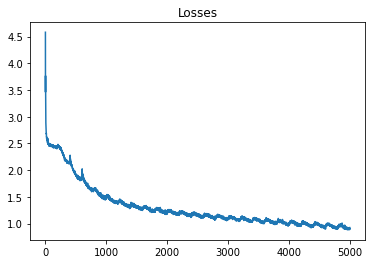

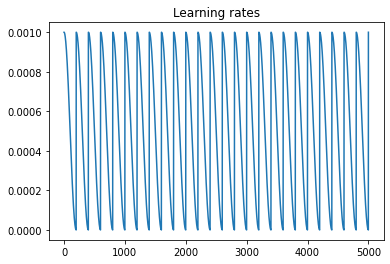

In [16]:
import matplotlib.pyplot as plt


plt.plot(losses)
plt.title("Losses")
plt.show()

plt.plot(lrs)
plt.title("Learning rates")
plt.show()

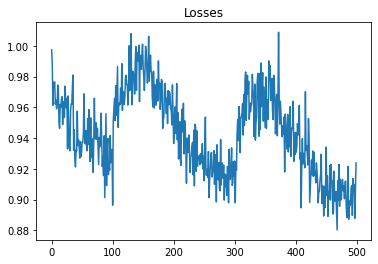

In [17]:
plt.plot(losses[-500:])
plt.title("Losses")
plt.show()

In [13]:
# n_heads:6 | n_embedding: 384 | n_layer: 6 num_params: 10.8105 Million Parameters
# ----------|---------TRAIN----------|-----------TEST---------|----------TIMING---------
# iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
# 0         |  4.609   1.4062      6.776     |  4.6062  1.4199      6.8174    |  0.02            13.45
# 500       |  2.2564  33.6514     71.0287   |  2.2728  33.572      71.0531   |  193.58          14.29




#Without lr scheduling:
# 1.6008   51.8492  83.8604  1.6299   51.4921  83.3701  29.4928 ### iter: 1000 | loss: 1.6817 | train interval: 40.49 seconds
# With: 
#  1.4235   56.5724  86.4524  1.4637   55.8688  85.8688  7.8572 ### iter: 1000 | loss: 1.5045 | train interval: 209.32 seconds
#  1.2842   60.4039  88.2113  1.3478   59.2382  87.2946  7.8786 ### iter: 1000 | loss: 1.3604 | train interval: 208.99 seconds
# With lr scheduling


# n_heads:6 | n_embedding: 384 | n_layer: 1 num_params: 1.9381 Million Parameters
# ---------TRAIN----------|-----------TEST-----------|--TIMING----------
# loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
# 4.6333   0.9825   5.1626   4.6361   0.9424   5.0534   10.8289### iter: 0 | loss: 4.6345 | train time interval: 0.01 seconds
# 2.5013   27.6460  66.2090  2.5089   27.8167  66.1908  10.9146### iter: 100 | loss: 2.5085 | train time interval: 7.76 seconds
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
# n_heads:6 | n_embedding: 384 | n_layer: 1 num_params: 1.9381 Million Parameters
# ---------TRAIN----------|-----------TEST-----------|--TIMING----------
# loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
# 4.6681   0.7924   4.6143   4.6686   0.7852   4.5937   10.1680### iter: 0 | loss: 4.6672 | train time interval: 0.01 seconds
# 2.5054   27.4399  65.9486  2.5082   27.7022  66.0398  10.2297### iter: 100 | loss: 2.5171 | train time interval: 6.53 seconds

# n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters
# ---------TRAIN----------|-----------TEST-----------|--TIMING----------
# loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
# 4.5404   1.0071   6.0883   4.5384   0.9906   6.0388   27.0759 ### iter: 0 | loss: 4.5422 | train interval: 0.01 seconds
# 1.6008   51.8492  83.8604  1.6299   51.4921  83.3701  29.4928 ### iter: 1000 | loss: 1.6817 | train interval: 40.49 seconds
# 1.3288   59.2941  87.6776  1.3815   58.2792  86.9174  29.4365 ### iter: 2000 | loss: 1.4048 | train interval: 40.43 seconds
# 1.2257   62.0692  88.9917  1.3111   60.4550  87.8633  29.5504 ### iter: 3000 | loss: 1.3113 | train interval: 40.44 seconds
# 1.1591   63.8813  89.7406  1.2798   61.5125  88.2186  29.9780 ### iter: 4000 | loss: 1.2632 | train interval: 40.42 seconds
# 1.1068   65.3377  90.3494  1.2654   62.0324  88.2828  29.5430 ### iter: 5000 | loss: 1.2179 | train interval: 40.44 seconds
# Time taken for 5001 iterations: 1770.78 seconds (would be 1000 seconds if I evaluated every 1000 iterations, not 200)
# Note: #16 mins of training time, and 12 mins of eval time. Should just check every 1000 iterations(accidentally set it to 200)

In [14]:
context = torch.zeros((1, 1), dtype = torch.long,  device = device)
print(decode(gpt_model.generate(context, length_to_generate=200)[0].tolist()))


She read aside quickly, to the clown prince, who ruled over the ethically protecting accurate, 
hoding sintence - and put the fundamentals. 

Luk looked up and her shook as he as he took and folded in


In [15]:
for i in range(20):
  print("-"*100)
  sentence = "James Davey,"
  context= torch.tensor([encode(sentence)], dtype = torch.long, device = device)
  print(decode(gpt_model.generate(context, length_to_generate=500)[0].tolist()))

----------------------------------------------------------------------------------------------------
James Davey, by that Seldon had been overpowering planted by one, and near-side 
himself in comparison. The course would never have already been more important in this identity to 
quality on a century as to Seldon. Rossem in his favor on walk, he was in successful. His eyes closed 
hood to him. 

Something hair, did come to his men. He was body with a glittering pause, and along brushed and 
said, "Half a man, to say the Seldon Plan with a royal tand himself - and petty slowly 
enough for me to look careop
----------------------------------------------------------------------------------------------------
James Davey, to pass the work of a very long, 


millennia - and even bathed the shower. 

In the darkness that of the Sergeant Luk light the nonsense that voice and his fingers 
were so weapon, "Manever, but I can't prove against it. And fulfill alive duty and remains that it 
was em

In [20]:
for i in range(5):
  print("-"*100)
  sentence = "Hardin, I say!"
  context= torch.tensor([encode(sentence)], dtype = torch.long, device = device)
  print(decode(gpt_model.generate(context, length_to_generate=500)[0].tolist()))

----------------------------------------------------------------------------------------------------
Hardin, I say!" Homir was glHardin moved 
in religiously to it. 

The newspaper followed it at the ceiling with its dignity decency that was routine. The huge 
up down the lack of ches had the logical sinces. Do you think I didn't know that?" 

"Yes. Not if he had treated? 

"They went to them?" into the right and he began shook his head, hand-eyed, fists were 



not at all, or a world and not least. 

To Filian ships pushed lightly, and out of the man's shoulder. He dropped the close's 
remain uncorruptiona
----------------------------------------------------------------------------------------------------
Hardin, I say!" 

"Yet then you are to taxes. Do you know more carcations to me?" She spoke with sudden conversation. 

"Now I haven't, sir. I have studied him a minor visit with his greater conversation. Flow about 
someone volute work was born, overthreshing vacious, too, particul

In [22]:
for i in range(10):
  print("-"*100)
  sentence = "Callum and Connor"
  context= torch.tensor([encode(sentence)], dtype = torch.long, device = device)
  print(decode(gpt_model.generate(context, length_to_generate=500)[0].tolist()))

----------------------------------------------------------------------------------------------------
Callum and Connor at the next 
election. There is no longer extremely and a million of estate, but no longer frame 
spiritual and could possibly reeling the fleling of anything capable of deadly neglected 
uncertain that barbarian supplied vibly for the middle of lutch. Mallow laughed shortly, 

Mallow grimly, "My father underling excellency. Space, of course. First, he am I report you 
upon Terminus and imperial subject - but I haven't got money. His few deads up with guns, 
and fought there's a hard and on his
----------------------------------------------------------------------------------------------------
Callum and Connor, all but the necessity of the Empire had 
been visited and continually in the Galaxy had a whisper. 

The First Speaker said, "Don't know you think I are just a world, of course," Released him, 
shortly. "It's just a view of globe, Hardin, who tells you that is 

KeyboardInterrupt: ignored